06-combine-two-mechanisms.ipynb
======================

In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Create plots.
* Make code modular (create a function for plotting).

## Load packages and read tables.

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# Read a summary table of the victimisation-based mechanism.
vic_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/vic_tab.parquet")
vic_tab.registerTempTable("vic_tab")

# Read a summary table of the observation-based mechanism.
obs_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/obs_tab.parquet")
obs_tab.registerTempTable("obs_tab")

In [52]:
# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.476ee023d...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...

## 1. Merge two tables.

In [53]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.53db3bd71...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [54]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs, 
                            CASE WHEN total_sev_dam IS NULL THEN 0 ELSE total_sev_dam END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.090ca369b...|2019-03-02|        3|      0|        0|      0|
|account.272b33c63...|2019-03-02|       11|      0|        1|      0|
|account.da692c372...|2019-03-02|        8|      1|        0|      0|
|account.53db3bd71...|2019-03-02|        1|      0|        1|      0|
|account.ab15ceb31...|2019-03-02|        1|      0|        0|      0|
|account.8d69e3520...|2019-03-02|       59|     21|        0|      0|
|account.11dbd81ee...|2019-03-02|        9|      1|        0|      0|
|account.da1a6fa0b...|2019-03-02|       35|     17|        0|      0|
|account.27478c512...|2019-03-02|       50|     16|        0|      0|
|account.e493e8036...|2019-03-02|       23|      0|        2|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

## 2. Get the number of times the motif appears in the network.

In [ ]:
# Find the number of cheaters who adopted cheating after being killed by cheating once and observing two cheaters.
merged_df.registerTempTable("merged_df")

motifs = spark.sql("SELECT * FROM merged_df WHERE total_exp = 1 AND total_obs = 2")
motifs.show()
print(motifs.count())

## 3. Plot the distribution of experiences and observations.

In [55]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(pairs_tab)

    total_obs  total_exp  freq
0           1          0     3
1           1          1     1
2           2          0     2
3           2          1     1
4           3          0     8
5           3          1     1
6           4          0     2
7           6          0     4
8           7          0     1
9           8          0     3
10          8          3     1
11          9          0     1
12         10          1     1
13         11          1     2
14         12          1     1
15         13          0     1
16         14          0     1
17         15          0     1
18         16          0     1
19         17          0     1
20         18          0     1
21         18          1     2
22         20          0     1
23         22          0     1
24         23          0     1
25         23          2     1
26         26          0     2
27         31          1     1
28         34          0     1
29         35          0     1
30         36          0     1
31      

In [56]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)

    sev_obs  sev_exp  freq
0         0        0    22
1         1        0     3
2         2        0     2
3         3        0     5
4         5        1     1
5         6        1     1
6         7        0     3
7         8        0     1
8         9        0     2
9         9        1     1
10       10        0     1
11       11        0     3
12       13        1     1
13       14        0     1
14       15        0     1
15       16        0     2
16       17        0     1
17       21        0     1
18       23        0     1
19       48        0     1


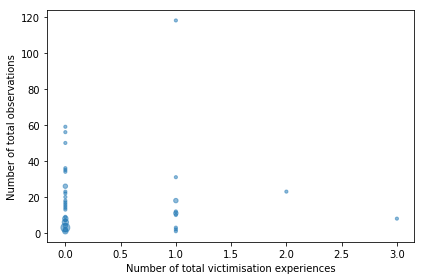

In [11]:
# Create a scatter plot.
fig = plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('Number of total victimisation experiences')
plt.ylabel('Number of total observations')
plt.tight_layout()
plt.show()

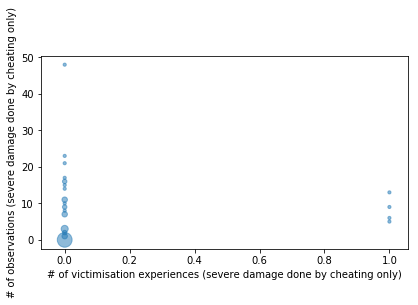

In [12]:
# Create a scatter plot.
fig = plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
                  s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.tight_layout()
plt.show()

In [13]:
# Add a little random noise to the data.
jittered_obs = pairs_tab['total_obs'] + 0.2 * np.random.rand(len(pairs_tab['total_obs'])) - 0.05
jittered_exp = pairs_tab['total_exp'] + 0.2 * np.random.rand(len(pairs_tab['total_exp'])) - 0.05

pairs_tab['jit_obs'] = jittered_obs
pairs_tab['jit_exp'] = jittered_exp

In [57]:
# Add a little random noise to the data.
jittered_sev_obs = sev_pairs_tab['sev_obs'] + 0.2 * np.random.rand(len(sev_pairs_tab['sev_obs'])) - 0.05
jittered_sev_exp = sev_pairs_tab['sev_exp'] + 0.1 * np.random.rand(len(sev_pairs_tab['sev_exp'])) - 0.05

sev_pairs_tab['jit_obs'] = jittered_sev_obs
sev_pairs_tab['jit_exp'] = jittered_sev_exp

In [15]:
# Store the table in the S3 bucket and export it as an excel file.
# merged_spark_df = spark.createDataFrame(merged_tab)
# merged_spark_df.write.parquet("s3://jinny-capstone-data-test/data-for-plots/emp-net/merged_table.parquet")
sev_pairs_tab.to_csv('merged_tab.csv')

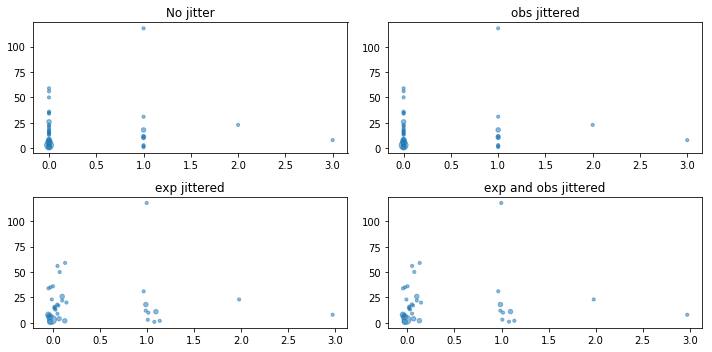

In [21]:
# Create scatter plots.
plt.figure(figsize=(10,5))

plt.subplot(221)
plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('No jitter')

plt.subplot(222)
plt.scatter(pairs_tab['total_exp'], pairs_tab['jit_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('obs jittered')

plt.subplot(223)
plt.scatter(pairs_tab['jit_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('exp jittered')

plt.subplot(224)
plt.scatter(pairs_tab['jit_exp'], pairs_tab['jit_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('exp and obs jittered')

plt.tight_layout()

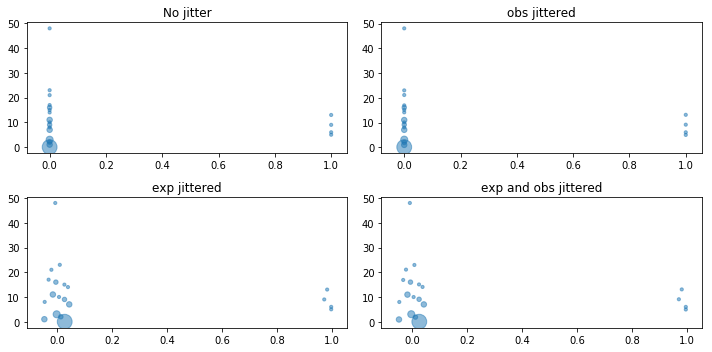

In [59]:
# Create scatter plots.
plt.figure(figsize=(10,5))

plt.subplot(221)
plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('No jitter')

plt.subplot(222)
plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['jit_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('obs jittered')

plt.subplot(223)
plt.scatter(sev_pairs_tab['jit_exp'], sev_pairs_tab['sev_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('exp jittered')

plt.subplot(224)
plt.scatter(sev_pairs_tab['jit_exp'], sev_pairs_tab['jit_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('exp and obs jittered')

plt.tight_layout()

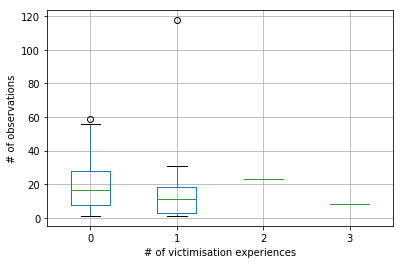

In [23]:
# Create box plots.
pairs_tab.boxplot(column='total_obs', by='total_exp')
plt.title('')
plt.suptitle('')
plt.xlabel("# of victimisation experiences")
plt.ylabel("# of observations")
plt.show()

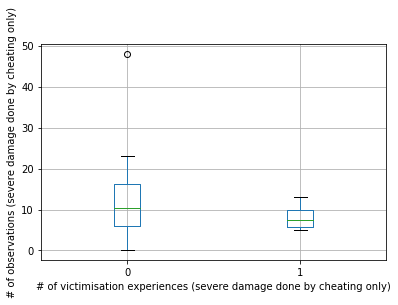

In [23]:
# Create box plots.
sev_pairs_tab.boxplot(column='sev_obs', by='sev_exp')
plt.title('')
plt.suptitle('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.show()

## 4. Create a merged data table for randomised networks.

In [45]:
# Read a summary table of the victimisation-based mechanism.
vic_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/rand-net/vic_tab_3.parquet")
vic_tab.registerTempTable("vic_tab")

# Read a summary table of the observation-based mechanism.
obs_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/rand-net/obs_tab_3.parquet")
obs_tab.registerTempTable("obs_tab")

# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...|2019-03-02|2019-03-01|     1|        2|            0|           1|
|account.70eb95960...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.c3d862798...

In [46]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
|account.71aea180f...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [47]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs, 
                            CASE WHEN total_sev_dam IS NULL THEN 0 ELSE total_sev_dam END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.090ca369b...|2019-03-02|        3|      0|        0|      0|
|account.272b33c63...|2019-03-02|        9|      0|        1|      0|
|account.da692c372...|2019-03-02|        8|      1|        0|      0|
|account.8d69e3520...|2019-03-02|       41|     20|        0|      0|
|account.11dbd81ee...|2019-03-02|        9|      1|        0|      0|
|account.da1a6fa0b...|2019-03-02|       17|      3|        0|      0|
|account.27478c512...|2019-03-02|       31|     10|        0|      0|
|account.e493e8036...|2019-03-02|       23|      0|        2|      0|
|account.71aea180f...|2019-03-02|        3|      3|        0|      0|
|account.ab15ceb31...|2019-03-02|        1|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

In [48]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(pairs_tab)

    total_obs  total_exp  freq
0           1          0     2
1           1          1     1
2           2          0     2
3           3          0     7
4           4          0     4
5           5          0     1
6           6          0     2
7           7          0     1
8           8          0     2
9           9          0     2
10          9          1     1
11         10          1     1
12         10          2     1
13         11          0     1
14         13          0     1
15         15          0     1
16         16          0     1
17         17          0     2
18         17          1     1
19         18          0     3
20         19          0     2
21         19          1     1
22         20          0     1
23         21          0     1
24         21          1     1
25         23          2     1
26         27          1     1
27         29          0     1
28         31          0     1
29         32          0     1
30         34          0     1
31      

In [49]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)

    sev_obs  sev_exp  freq
0         0        0    17
1         1        0     3
2         2        0     2
3         3        0     9
4         4        0     2
5         5        0     1
6         5        1     1
7         7        0     2
8         9        0     2
9         9        1     1
10       10        0     1
11       11        0     1
12       12        0     2
13       14        1     1
14       15        0     1
15       17        0     1
16       19        0     1
17       20        0     2
18       23        0     1
19       60        0     1


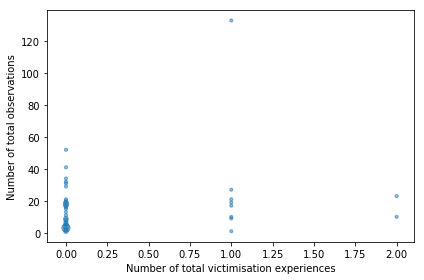

In [25]:
# Create a scatter plot.
fig = plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('Number of total victimisation experiences')
plt.ylabel('Number of total observations')
plt.tight_layout()
plt.show()

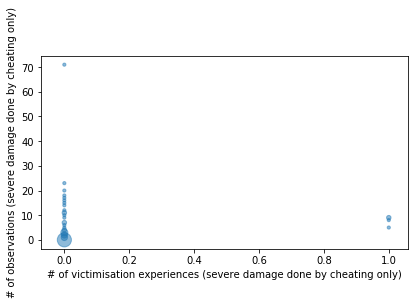

In [29]:
# Create a scatter plot.
fig = plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
                  s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.tight_layout()
plt.show()

In [30]:
# Add a little random noise to the data.
jittered_obs = pairs_tab['total_obs'] + 0.2 * np.random.rand(len(pairs_tab['total_obs'])) - 0.05
jittered_exp = pairs_tab['total_exp'] + 0.2 * np.random.rand(len(pairs_tab['total_exp'])) - 0.05

pairs_tab['jit_obs'] = jittered_obs
pairs_tab['jit_exp'] = jittered_exp

In [50]:
# Store the table in the S3 bucket and export it as an excel file.
# merged_spark_df = spark.createDataFrame(pairs_tab)
# merged_spark_df.write.parquet("s3://jinny-capstone-data-test/data-for-plots/rand-net/merged_table_3.parquet")
sev_pairs_tab.to_csv('merged_tab_rand_3.csv')

In [36]:
# Add a little random noise to the data.
jittered_sev_obs = sev_pairs_tab['sev_obs'] + 0.2 * np.random.rand(len(sev_pairs_tab['sev_obs'])) - 0.05
jittered_sev_exp = sev_pairs_tab['sev_exp'] + 0.1 * np.random.rand(len(sev_pairs_tab['sev_exp'])) - 0.05

sev_pairs_tab['jit_obs'] = jittered_sev_obs
sev_pairs_tab['jit_exp'] = jittered_sev_exp

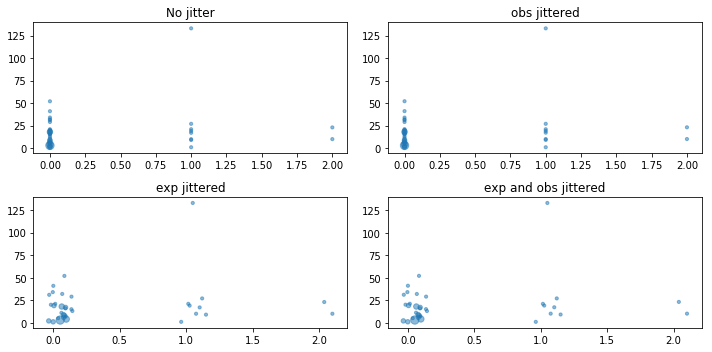

In [28]:
# Create scatter plots.
plt.figure(figsize=(10,5))

plt.subplot(221)
plt.scatter(pairs_tab['total_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('No jitter')

plt.subplot(222)
plt.scatter(pairs_tab['total_exp'], pairs_tab['jit_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('obs jittered')

plt.subplot(223)
plt.scatter(pairs_tab['jit_exp'], pairs_tab['total_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('exp jittered')

plt.subplot(224)
plt.scatter(pairs_tab['jit_exp'], pairs_tab['jit_obs'], s=pairs_tab['freq']*10, alpha=0.5)
plt.title('exp and obs jittered')

plt.tight_layout()

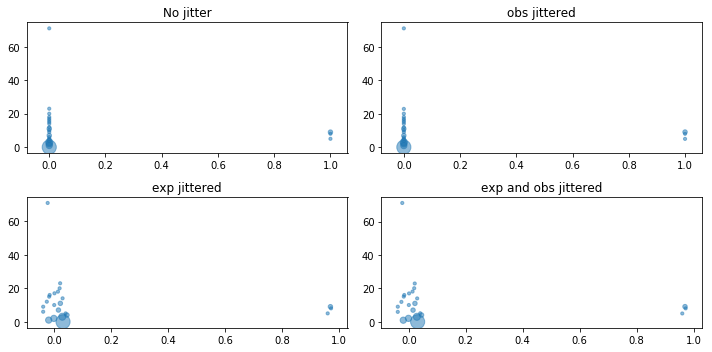

In [37]:
# Create scatter plots.
plt.figure(figsize=(10,5))

plt.subplot(221)
plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['sev_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('No jitter')

plt.subplot(222)
plt.scatter(sev_pairs_tab['sev_exp'], sev_pairs_tab['jit_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('obs jittered')

plt.subplot(223)
plt.scatter(sev_pairs_tab['jit_exp'], sev_pairs_tab['sev_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('exp jittered')

plt.subplot(224)
plt.scatter(sev_pairs_tab['jit_exp'], sev_pairs_tab['jit_obs'], 
            s=sev_pairs_tab['freq']*10, alpha=0.5)
plt.title('exp and obs jittered')

plt.tight_layout()

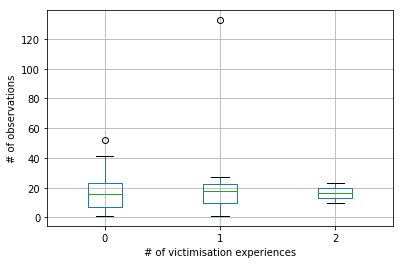

In [29]:
# Create box plots.
pairs_tab.boxplot(column='total_obs', by='total_exp')
plt.title('')
plt.suptitle('')
plt.xlabel("# of victimisation experiences")
plt.ylabel("# of observations")
plt.show()

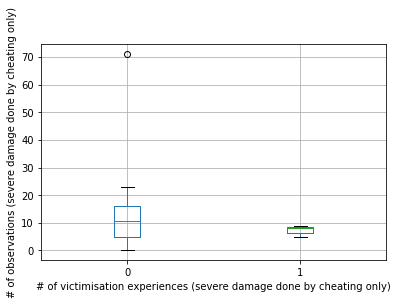

In [38]:
# Create box plots.
sev_pairs_tab.boxplot(column='sev_obs', by='sev_exp')
plt.title('')
plt.suptitle('')
plt.xlabel('# of victimisation experiences (severe damage done by cheating only)')
plt.ylabel('# of observations (severe damage done by cheating only)')
plt.show()